# 1EG 

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [199]:
df = pd.read_csv('../data/1EG.csv')

In [200]:
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR
0,22419412,NaN,NaN,-0.866025,0.5,10,2010,0.019850,3.494
1,22419413,NaN,NaN,-0.866025,0.5,10,2010,0.009742,1.153
2,22419415,NaN,NaN,-0.866025,0.5,10,2010,0.044751,5.955
3,22419420,NaN,NaN,-0.866025,0.5,10,2010,0.007539,1.829
4,22419422,NaN,NaN,-0.866025,0.5,10,2010,0.053865,4.536


In [201]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 661191 entries, 0 to 661190
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_STANA    661191 non-null  int64  
 1   POVRSINA    268818 non-null  float64
 2   BR_OSOBA    25190 non-null   float64
 3   MJESEC_sin  661191 non-null  float64
 4   MJESEC_cos  661191 non-null  float64
 5   MJESEC      661191 non-null  int64  
 6   GODINA      661191 non-null  int64  
 7   S_SNAGA     661069 non-null  float64
 8   ENESGR      521802 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 45.4 MB


Ako je ENESGR jednako nula ili null to izbacujemo iz skupa

In [202]:
df = df[df['ENESGR'].notna() & (df['ENESGR'] != 0)]

In [203]:
df.info()

<class 'pandas.DataFrame'>
Index: 470856 entries, 0 to 661181
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_STANA    470856 non-null  int64  
 1   POVRSINA    193699 non-null  float64
 2   BR_OSOBA    23095 non-null   float64
 3   MJESEC_sin  470856 non-null  float64
 4   MJESEC_cos  470856 non-null  float64
 5   MJESEC      470856 non-null  int64  
 6   GODINA      470856 non-null  int64  
 7   S_SNAGA     470856 non-null  float64
 8   ENESGR      470856 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 35.9 MB


In [204]:
# Sto ako izbacimo sve retke koji za povrsinu imaju 0 ili null? 
# (Od)komentiraj ovaj blok.
df = df[df['POVRSINA'].notna() & (df['POVRSINA'] != 0)]

In [205]:
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR
742,22743491,100.0,NaN,-8.660254e-01,0.500000,10,2010,0.032078,3.563
1418,24079494,100.0,NaN,-8.660254e-01,0.500000,10,2010,0.032660,5.115
7180,24079494,100.0,NaN,-5.000000e-01,0.866025,11,2010,0.032660,5.683
9457,24079494,100.0,NaN,-2.449294e-16,1.000000,12,2010,0.032660,9.661
16844,24079494,100.0,NaN,5.000000e-01,0.866025,1,2011,0.032660,10.229


In [229]:
df.info()

<class 'pandas.DataFrame'>
Index: 193656 entries, 742 to 661181
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_STANA    193656 non-null  int64  
 1   POVRSINA    193656 non-null  float64
 2   BR_OSOBA    23005 non-null   float64
 3   MJESEC_sin  193656 non-null  float64
 4   MJESEC_cos  193656 non-null  float64
 5   MJESEC      193656 non-null  int64  
 6   GODINA      193656 non-null  int64  
 7   S_SNAGA     193656 non-null  float64
 8   ENESGR      193656 non-null  float64
 9   cluster     193656 non-null  int32  
dtypes: float64(6), int32(1), int64(3)
memory usage: 15.5 MB


## Grafovi

### Provjera korelacija

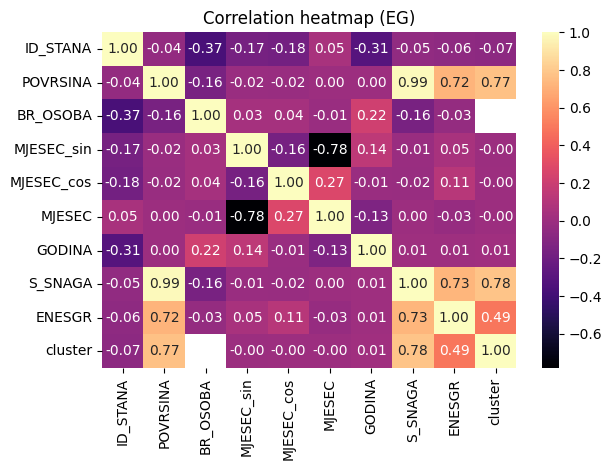

In [228]:
corr = df.corr()

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

Vidimo da zapravo korelacija izmedu mjeseca i potrosnje nije toliko bitna, ali je snaga na jedinici preko koje se direktno i racuna potrosnja. Takoder vidimo da broj osoba nema utjecaja, ali povrsina je jako korelirana i to cemo koristiti u nastavku.

## Trendovi podataka

In [207]:
def diagnose_features(data, features, target):
    """
    Metoda za graficki pregled trendova u podatcima.
    """
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


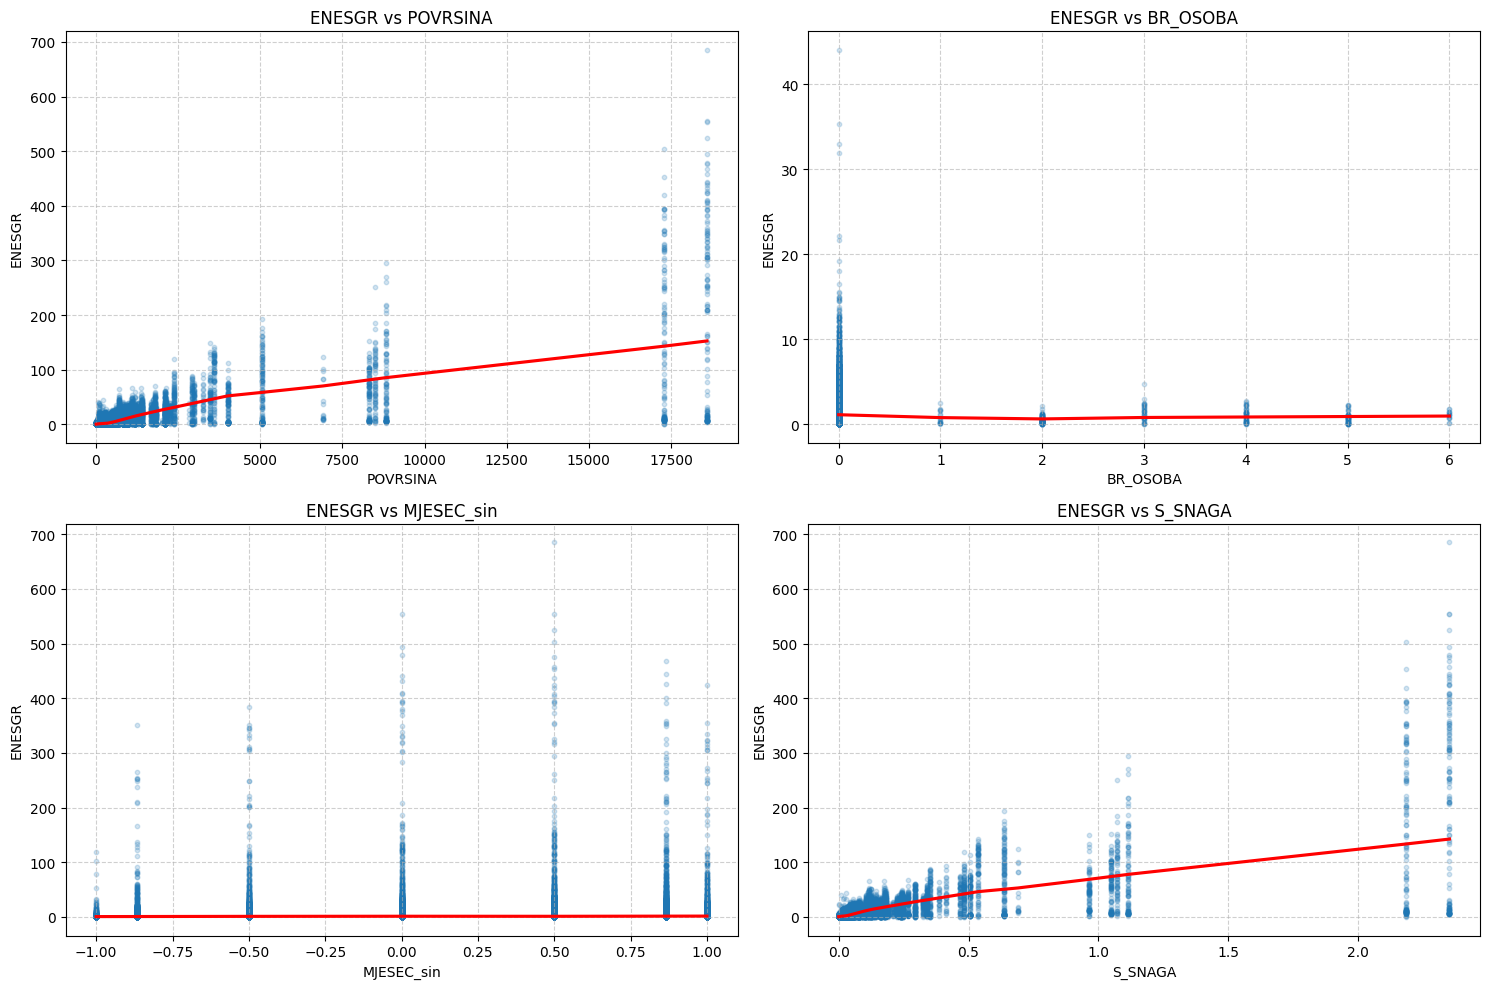

In [208]:
diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'S_SNAGA'], 'ENESGR')

Ovime smo se uvjerili da broj osoba ima zanemariv ucinak na ukupnu potrosnju energije neke jedinice.

## Grupiranje 

### K-sredina

In [209]:
from sklearn.metrics import silhouette_score

def find_optimal_k(data, features, title):
    """
    Metoda za trazenje optimaknog broja grupa k nad podatcima i znacajkama
    """
    
    X_sub = data[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)
    
    inertia = []
    silhouette_avg = []
    K_range = range(2, 9)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia.append(kmeans.inertia_)
        
        # Silhouette na uzorku zbog brzine ako je dataset velik
        # Ovo mozda maknuti -> presporo
        sample_size = min(len(X_scaled), 5000)
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        current_silhouette = silhouette_score(X_scaled[idx], labels[idx])
        silhouette_avg.append(current_silhouette)
        print(f"{k:<5} | {current_silhouette:<15.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Broj klastera (k)')
    ax1.set_ylabel('Inertia (Lakat)', color='blue')
    ax1.plot(K_range, inertia, 'bo-')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score (Više je bolje)', color='red')
    ax2.plot(K_range, silhouette_avg, 'ro-')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Određivanje optimalnog k za: {title}')
    plt.show()

2     | 0.9878         
3     | 0.9684         
4     | 0.9290         
5     | 0.9018         
6     | 0.5928         
7     | 0.5515         
8     | 0.5168         


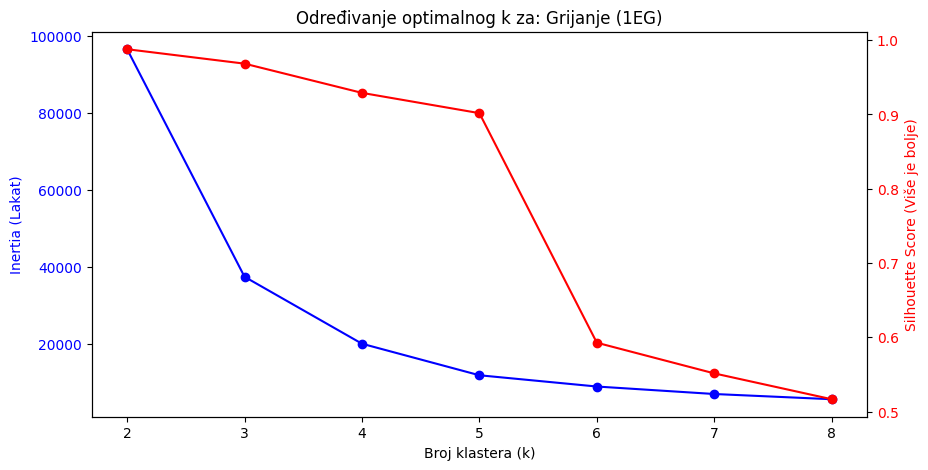

In [210]:
# Procjena optimalnog broja grupa
_features = ['POVRSINA', "S_SNAGA"]
find_optimal_k(df, _features, "Grijanje (1EG)")

Najbolji odabir broja grupa je 3, 4 ili 5 iz ovoga. Nastavljamo sa 3 grupe.

In [211]:
def perform_clustering(data, features, n_clusters=4):
    """ 
    Metoda za grupiranje podataka.
    """
    df_sub = data[features].dropna().copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_sub)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_sub['cluster'] = kmeans.fit_predict(scaled_data)
    
    return df_sub['cluster']

In [212]:
df['cluster'] = perform_clustering(df, _features, 3)
print(f"Klasteri:\n{df['cluster'].value_counts()}")

Klasteri:
cluster
0    192493
2       903
1       260
Name: count, dtype: int64


In [213]:
def plot_clustering_2d(data, features):
    """
    Metoda za graficki prikaz grupa.
    """
    if 'cluster' not in df.columns:
        print("Klasteri nisu pronađeni u DataFrame-u. Molimo pokrenite perform_clustering prvo.")

    # Izracun centroida 
    centroids = df.groupby('cluster')[features].mean().reset_index()
    
    plt.figure(figsize=(10, 7))
    
    sns.scatterplot(
        data=df, 
        x=features[0],
        y=features[1],
        hue='cluster', 
        palette='viridis', 
        s=50,             
        alpha=0.6,        
        edgecolor='w',    
        legend='full'     
    )
    
    # Crtanje centroida 
    sns.scatterplot(
        data=centroids, 
        x=features[0],
        y=features[1],
        marker='X',        
        s=250,             
        color='red',       
        edgecolor='black', 
        label='Centroidi'  
    )
    
    plt.title('Klasteri i Centroidi')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

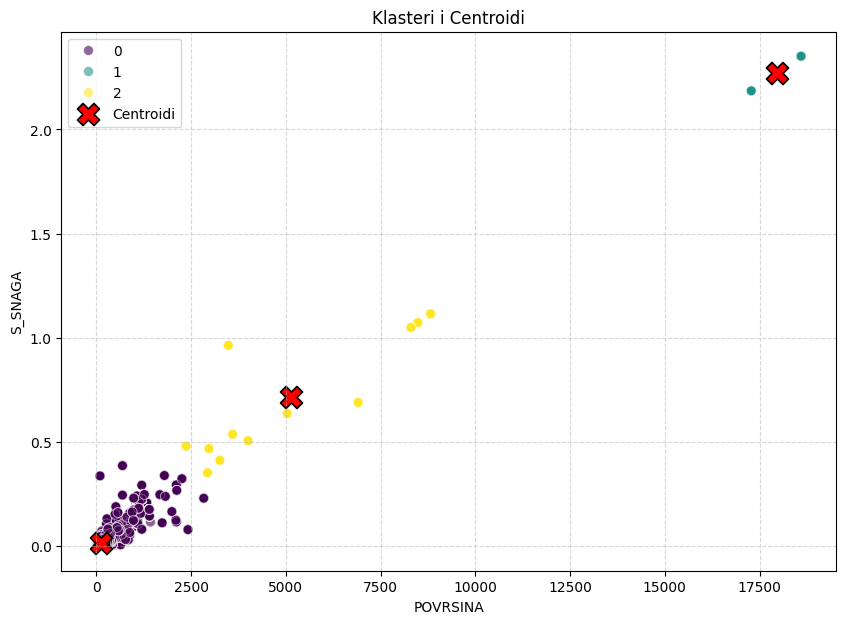

In [214]:
plot_clustering_2d(df, _features)

Ovdje vidimo problem da puno stanova ima vrijednost povrsine 0 (vjerojatno nije nikad mjerena jer ne ulazi u izracun).

In [215]:
def analyze_clusters(data, features, target=None):
    """
    Racuna prosjek i standardnu devijaciju za zadane znacajke po klasterima.
    """
    cols_to_analyze = features.copy()
    if target:
        cols_to_analyze.append(target)
    
    # Grupiranje po klasteru i racunanje agregacija
    analysis = data.groupby('cluster')[cols_to_analyze].agg(['mean', 'std'])
    
    analysis.columns = [f"{col}_{stat}" for col, stat in analysis.columns]
    
    print("--- Analiza klastera (Prosjek i Std Dev) ---")
    return analysis

In [216]:
cluster_stats = analyze_clusters(df, _features, target='ENESGR')
display(cluster_stats)
print(cluster_stats)

--- Analiza klastera (Prosjek i Std Dev) ---


,POVRSINA_mean,POVRSINA_std,S_SNAGA_mean,S_SNAGA_std,ENESGR_mean,ENESGR_std
cluster,,,,,,
0,128.986275,179.014828,0.016304,0.024818,1.852885,3.210912
1,17948.777846,657.873642,2.269282,0.083175,172.420008,161.136314
2,5129.397575,2342.371540,0.718485,0.272995,52.840978,45.715282


         POVRSINA_mean  POVRSINA_std  S_SNAGA_mean  S_SNAGA_std  ENESGR_mean  \
cluster                                                                        
0           128.986275    179.014828      0.016304     0.024818     1.852885   
1         17948.777846    657.873642      2.269282     0.083175   172.420008   
2          5129.397575   2342.371540      0.718485     0.272995    52.840978   

         ENESGR_std  
cluster              
0          3.210912  
1        161.136314  
2         45.715282  


Vidimo da od ovog pristupa nismo dobili nista konkretno.

## Linearni modeli

In [217]:
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

def detect_outliers_regression(data, features, target):
    """
    Metoda za odredivanje outliera na temelju linearne regresije.
    """
    df_reg = data.copy().dropna(subset=features + [target])
    
    # 1. Treniranje modela
    X = df_reg[features]
    y = df_reg[target]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 2. Predvidanje
    df_reg['prediction'] = model.predict(X)
    df_reg['residual'] = df_reg[target] - df_reg['prediction']
    
    # 3. Izracun standardne devijacije reziduala (sigma)
    sigma = np.std(df_reg['residual'])
    
    # Racunamo Z-score za detekciju
    df_reg['z_score'] = zscore(df_reg['residual'])
    
    # Definiramo outliere (izvan +/- 3 sigme)
    outliers = df_reg[df_reg['z_score'] > 3] 
    normals = df_reg[df_reg['z_score'] <= 3]
    
    print(f"Pronadeno {len(outliers)} ekstrema od {len(df_reg)} zapisa (Sigma={sigma:.2f}).")
    
    plt.figure(figsize=(12, 8))
    plt.scatter(normals['prediction'], normals[target], 
                c='blue', alpha=0.3, s=20, label='Normalna potrosnja')
    plt.scatter(outliers['prediction'], outliers[target], 
                c='red', alpha=0.9, s=50, edgecolors='black', label='Outlieri (>3σ)')
    line_x = np.linspace(df_reg['prediction'].min(), df_reg['prediction'].max(), 100)
    plt.plot(line_x, line_x, color='black', linestyle='--', linewidth=2, label='Idealno predvidanje')
    plt.fill_between(line_x, 
                     line_x - 3*sigma, 
                     line_x + 3*sigma, 
                     color='green', alpha=0.15, label='Zona tolerancije (±3σ)')
    
    plt.xlabel(f'Ocekivana potrošnja - Model ({target})')
    plt.ylabel(f'Stvarna potrošnja ({target})')
    plt.title(f'Detekcija Outliera: Stvarno vs. Očekivano\n(Varijable: {", ".join(features)})')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()
    
    return outliers.sort_values(by='z_score', ascending=False)

Pronadeno 629 ekstrema od 193656 zapisa (Sigma=7.06).


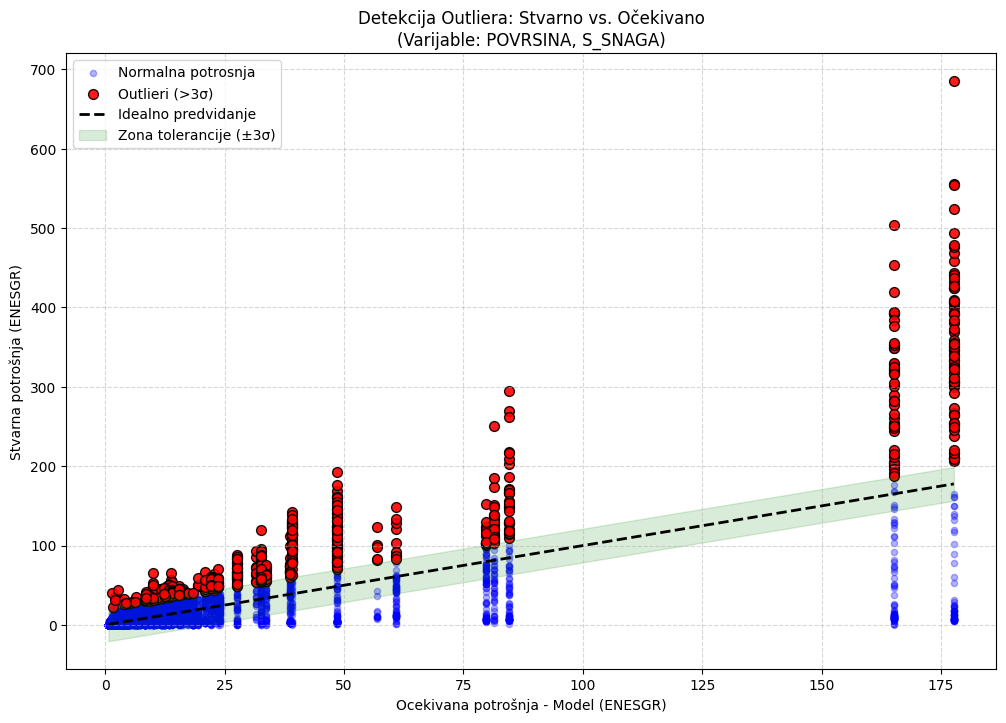

In [218]:
outliers = detect_outliers_regression(df, _features, 'ENESGR')

## Grupiranje s ciljnom varijablom 

Iako se ovakav pristup inace izbjegava, ovime bi mogli stvoriti "energetske razrede".

## K-sredina

2     | 0.9794         
3     | 0.9752         
4     | 0.9637         
5     | 0.9003         
6     | 0.8924         
7     | 0.8929         
8     | 0.7538         


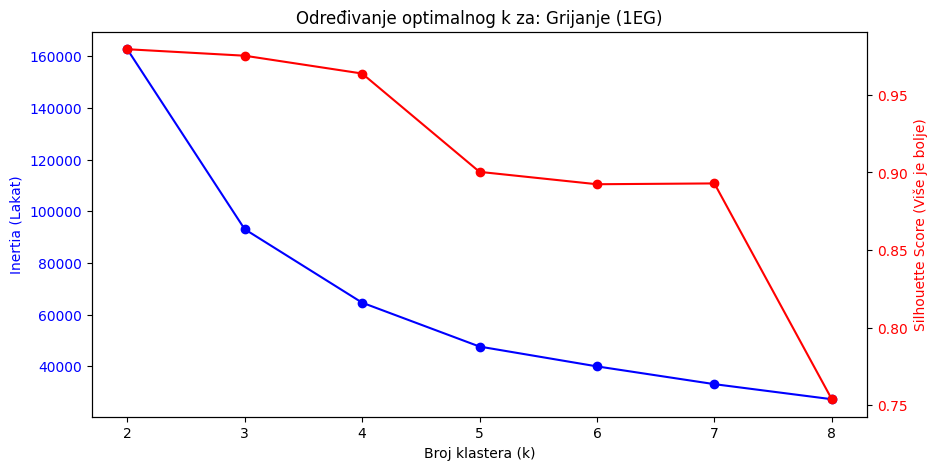

In [219]:
# Procjena optimalnog broja grupa
_features = ['POVRSINA', "ENESGR"]
find_optimal_k(df, _features, "Grijanje (1EG)")

Sada cemo uzeti 4 razreda.

In [220]:
df['cluster'] = perform_clustering(df, _features, 4)
print(f"Klasteri:\n{df['cluster'].value_counts()}")

Klasteri:
cluster
0    192564
2       826
3       141
1       125
Name: count, dtype: int64


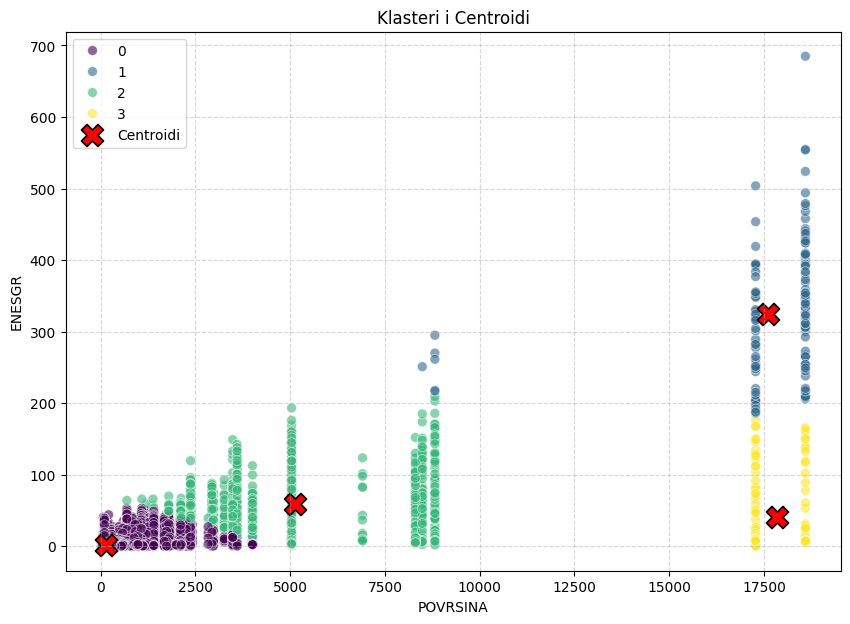

In [221]:
plot_clustering_2d(df, _features)

Iako objekti ogromne povrsine ovdje izgledaju kao da su krivo grupirani, ali interpretacija ovoga bi
mogla biti da je zuta grupa zapravo skup negrijanih jedinica koje ili sluze za nekakve ostave ili zbog nekog drugog razloga nisu useljene.

In [222]:
cluster_stats = analyze_clusters(df, _features, target='ENESGR')
display(cluster_stats)

--- Analiza klastera (Prosjek i Std Dev) ---


,POVRSINA_mean,POVRSINA_std,ENESGR_mean,ENESGR_std,ENESGR_mean,ENESGR_std
cluster,,,,,,
0,130.677859,196.241772,1.838654,3.067190,1.838654,3.067190
1,17619.104960,2094.014625,325.271464,91.245283,325.271464,91.245283
2,5138.459758,2487.374933,59.094096,39.983612,59.094096,39.983612
3,17850.185532,653.015408,40.303043,50.259878,40.303043,50.259878


## Regresija po grupama

In [223]:
def perform_cluster_regression(df, features, target):
    """
    Metoda za odredivanje regresijskog pravca po grupiranim podatcima.
    """
    df_res = df.copy()
    
    # Priprema stupaca
    df_res['prediction'] = np.nan
    df_res['residual'] = np.nan
    df_res['z_score_local'] = np.nan
    
    clusters = sorted(df_res['cluster'].unique())
    
    print(f"{'Klaster':<10} | {'Prosjek (kWh)':<15} | {'Lokalna Sigma':<15}")
    print("-" * 45)

    for cl in clusters:
        # Filtriranje podataka za klaster
        mask = df_res['cluster'] == cl
        subset = df_res[mask]
        
        if len(subset) < 2: continue
        
        # Treniranje modela
        X = subset[features]
        y = subset[target]
        model = LinearRegression()
        model.fit(X, y)
        
        preds = model.predict(X)
        resids = y - preds
        
        # Lokalna sigma 
        local_sigma = np.std(resids)
        
        df_res.loc[mask, 'prediction'] = preds
        df_res.loc[mask, 'residual'] = resids
        # Lokalni Z-score
        df_res.loc[mask, 'z_score_local'] = resids / local_sigma if local_sigma > 0 else 0
        
        print(f"{cl:<10} | {y.mean():<15.2f} | {local_sigma:<15.2f}")
        
    # Oznacavanje outliera 
    df_res['is_outlier'] = df_res['z_score_local'].abs() > 3
    
    return df_res

Klaster    | Prosjek (kWh)   | Lokalna Sigma  
---------------------------------------------
0          | 1.84            | 2.49           
1          | 325.27          | 87.94          
2          | 59.09           | 39.95          
3          | 40.30           | 50.07          


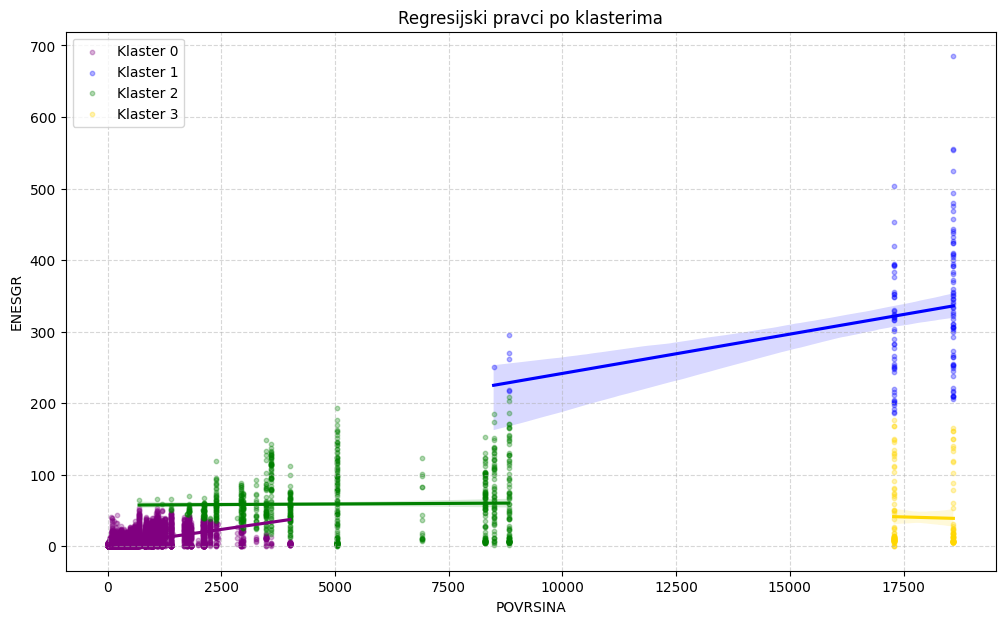

In [224]:
features = ['POVRSINA']
df_final = perform_cluster_regression(df, features, 'ENESGR')

plt.figure(figsize=(12, 7))
colors = ['purple', 'blue', 'green', 'gold']
for i, cl in enumerate(sorted(df_final['cluster'].unique())):
    subset = df_final[df_final['cluster'] == cl]
    sns.regplot(data=subset, x='POVRSINA', y='ENESGR', 
                scatter=True, label=f'Klaster {cl}', 
                color=colors[i], scatter_kws={'alpha':0.3, 's':10})

plt.title('Regresijski pravci po klasterima')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

WOW :) 

In [225]:
import statsmodels.formula.api as smf

def quantile_detection_by_cluster(df, q_level=0.95):
    df_res = df.copy()
    df_res['quant_limit'] = np.nan
    df_res['is_quant_outlier'] = False
    
    clusters = sorted(df_res['cluster'].unique())
    
    for cl in clusters:
        mask = df_res['cluster'] == cl
        subset = df_res[mask]
        
        if len(subset) < 10:
            continue
            
        # Modeliranje po klasteru
        try:
            model = smf.quantreg('ENESGR ~ POVRSINA', subset).fit(q=q_level)
            
            df_res.loc[mask, 'quant_limit'] = model.predict(subset)
            df_res.loc[mask, 'is_quant_outlier'] = df_res.loc[mask, 'ENESGR'] > df_res.loc[mask, 'quant_limit']
        except:
            print(f"Problem s izracunom za klaster {cl}")
            
    return df_res

In [226]:
df_final = quantile_detection_by_cluster(df_final, q_level=0.95)

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Ovo nam ne donosi nista novo.

## Time series?  

Vidimo da sa prijasnim pokusajima imamo malo uspjeha (iako zapravo ne znamo postoje li ovdje uopce outlieri). 
Idemo pokusati promatrati stan kao vremenski niz. Mozda nije zapravo problem ako stan trosi vise nego ostali stanovi slicne povrsine ako je to konzistentno.

In [239]:
import random

def plot_random_time_series(df, n_apartments=5):
    """
    Metoda za prikaz vremenske serije potrosnje nasumicno odabranih stanova.
    """
    df_ts = df.copy()
    
    df_ts['Date'] = pd.to_datetime(
        df_ts[['GODINA', 'MJESEC']]
        .rename(columns={'GODINA': 'year', 'MJESEC': 'month'}) # PANDAS JE SHIT
        .assign(day=1)
    )
    
    # 2. Odabir 5 nasumičnih ID-ova stanova
    unique_ids = df_ts['ID_STANA'].unique()
    random_ids = random.sample(list(unique_ids), min(n_apartments, len(unique_ids)))
    
    # 3. Filtriranje i sortiranje po datumu 
    subset = df_ts[df_ts['ID_STANA'].isin(random_ids)].sort_values(['ID_STANA', 'Date'])
    
    # 4. Vizualizacija
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=subset, x='Date', y='ENESGR', hue='ID_STANA', 
                 marker='o', palette='tab10', linewidth=2)
    
    plt.title(f'Vremenski trend potrosnje za {n_apartments} nasumicnih stanova')
    plt.xlabel('Datum')
    plt.ylabel('Potrosnja (ENESGR)')
    plt.legend(title='ID Stana', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

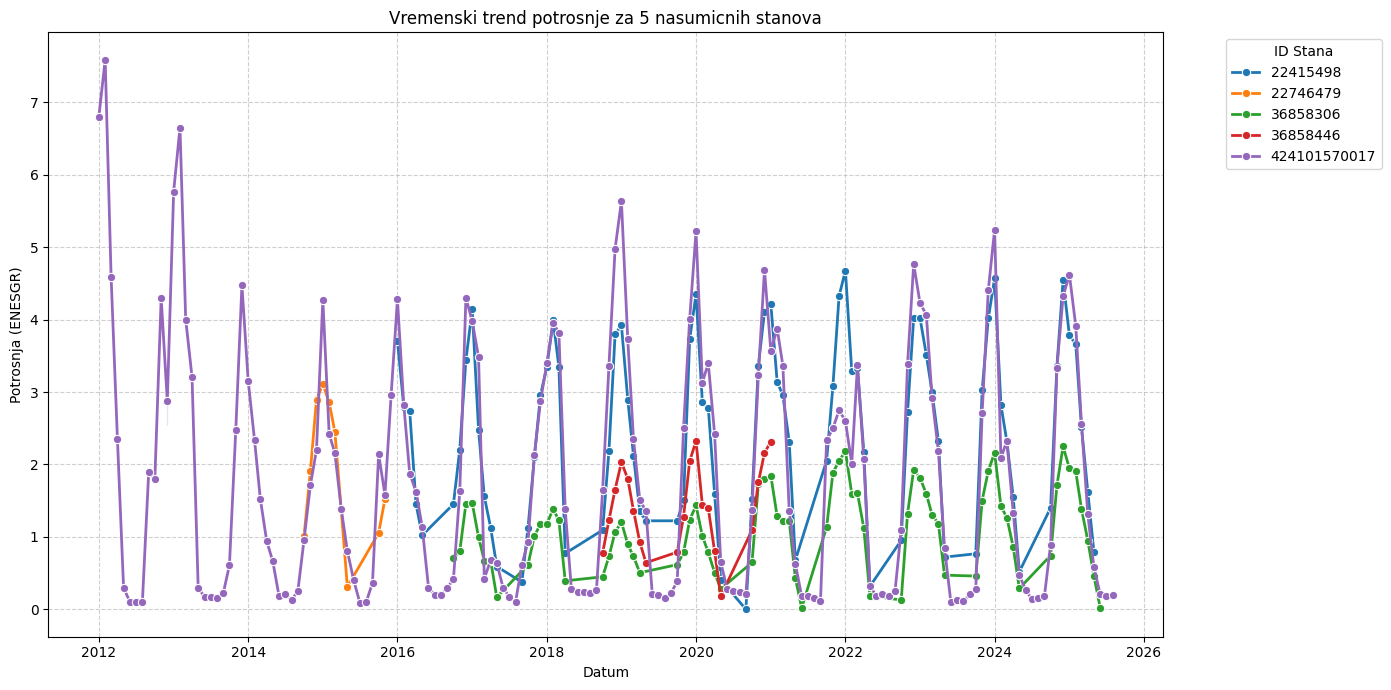

In [240]:
plot_random_time_series(df_final, n_apartments=5)

Ovdje vidimo odlican primjer velike sezonalnosti sto i ocekujemo.